Ham veri oluşturuluyor...
Ham veri boyutu: (256, 256)
Hedef sayısı: 3


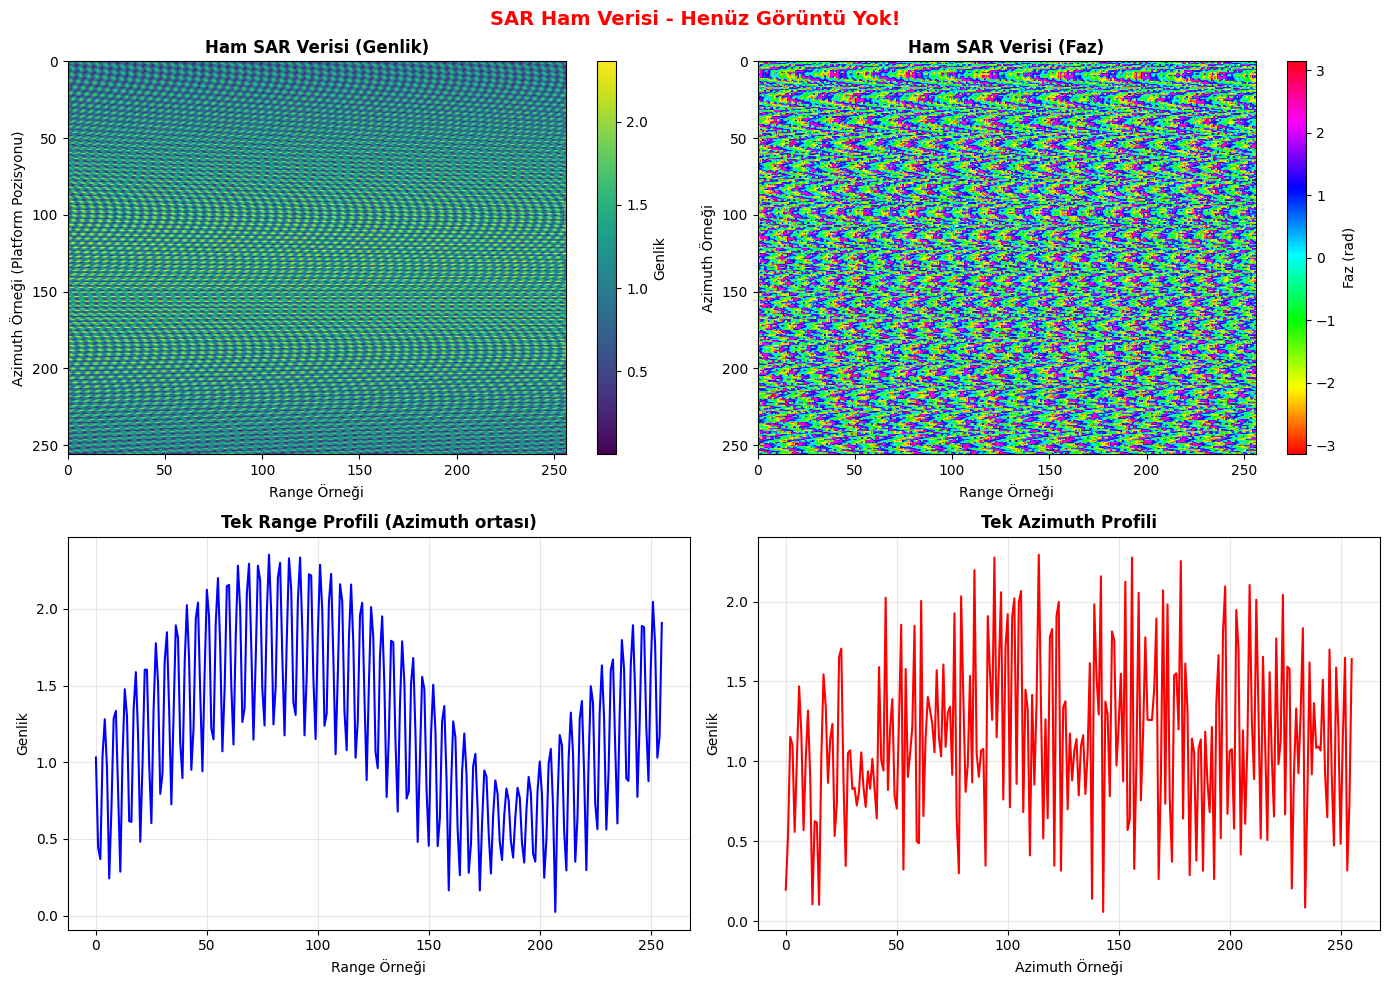


Range compression uygulanıyor...


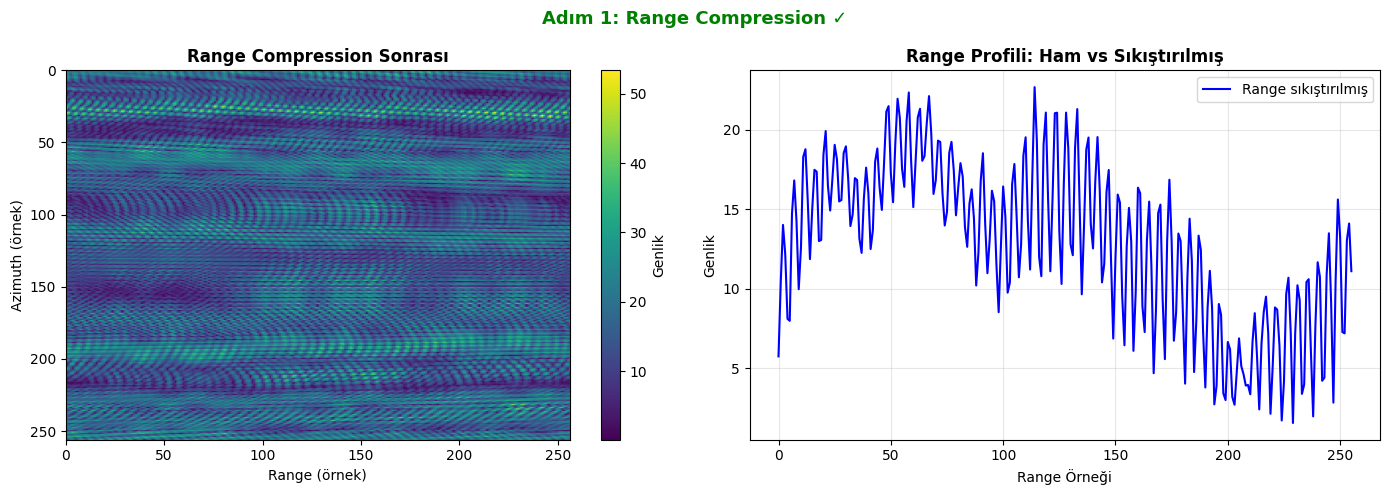

Azimuth compression uygulanıyor...


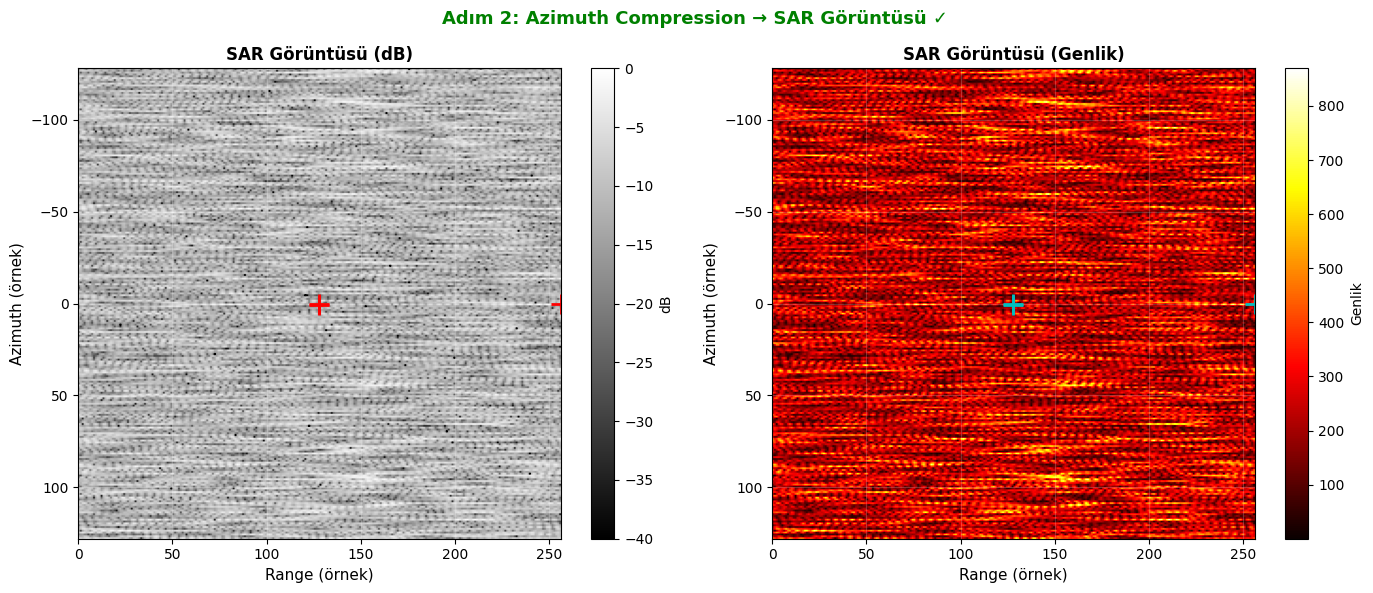


SAR GÖRÜNTÜLEME TAMAMLANDI!
Ham veri boyutu: (256, 256)
SAR görüntü boyutu: (256, 256)
Range çözünürlüğü: 1.00 m
Azimuth çözünürlüğü: 0.050 m


"\n\n---\n\n## Ne Gördünüz?\n\nSimülasyon size 4 aşamayı gösterdi:\n\n**1. Ham veri:** Düzensiz, karmaşık, içinden hedef seçilemiyor. Sadece ham ölçümler.\n\n**2. Ham faz:** Hiperbolik örüntüler görünür. Her hedefin izi bir kavis çizer.\n\n**3. Range compression sonrası:** Range yönünde keskinleşti. Azimuth hala bulanık.\n\n**4. SAR görüntüsü:** Her iki yönde de keskin noktalar. Hedefler ayrıştı!\n\n---\n\n```\n\n## Özet: SAR'ın Tam Akışı\n```\nPlatform hareket eder\n        ↓\nHer pozisyonda chirp gönderir/alır\n        ↓\n2D Ham veri matrisi oluşur\n        ↓\nRange Compression (Matched Filter)\n        ↓\nAzimuth Compression (Doppler FFT)\n        ↓\nSAR Görüntüsü\n\n"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# PARAMETRELER
# ============================================
c = 3e8                # Işık hızı
f_c = 10e9             # Merkez frekans (10 GHz)
lambda_c = c / f_c     # Dalga boyu (3 cm)

# FMCW Chirp parametreleri
B = 150e6              # Bant genişliği (150 MHz)
T_chirp = 1e-3         # Chirp süresi
K = B / T_chirp        # Chirp rate (frekans değişim hızı)

# Platform parametreleri
v = 50                 # Platform hızı (m/s)
H = 0                  # Yükseklik (basitlik için 0)

# Örnekleme
fs_range = 2 * B       # Range örnekleme frekansı
N_range = 256          # Range örnek sayısı
N_azimuth = 256        # Azimuth örnek sayısı (platform pozisyon sayısı)

# ============================================
# HEDEFLER
# ============================================
targets = [
    {'range': 1000, 'azimuth': 0,    'amplitude': 1.0},   # Merkez hedef
    {'range': 1000, 'azimuth': 50,   'amplitude': 0.8},   # Sağda hedef
    {'range': 1200, 'azimuth': -30,  'amplitude': 0.6},   # Uzakta sol hedef
]

# ============================================
# ZAMAN EKSENLERİ
# ============================================
# Range (hızlı zaman)
t_range = np.linspace(0, T_chirp, N_range)

# Azimuth (yavaş zaman)
t_azimuth = np.linspace(-N_azimuth/2, N_azimuth/2, N_azimuth) / v

# Platform pozisyonları
y_platform = v * t_azimuth

# ============================================
# HAM VERİ OLUŞTURMA
# ============================================
raw_data = np.zeros((N_azimuth, N_range), dtype=complex)

print("Ham veri oluşturuluyor...")
for target in targets:
    R0 = target['range']     # En yakın mesafe
    az0 = target['azimuth']  # Azimuth pozisyonu
    amp = target['amplitude']

    for i, yp in enumerate(y_platform):
        # Anlık mesafe (hiperbolik)
        R_instant = np.sqrt(R0**2 + (yp - az0)**2)

        # Gidiş-dönüş gecikmesi
        tau = 2 * R_instant / c

        # Chirp sinyali (karmaşık baseband)
        # Faz = chirp fazı + taşıyıcı fazı
        phase = 2 * np.pi * (
            f_c * tau +             # Taşıyıcı gecikmesi
            K * tau * t_range -     # Chirp beat frekansı
            0.5 * K * tau**2        # Sabit faz terimi
        )

        # Işın genişliği ağırlıklandırması
        angle = np.arctan((yp - az0) / R0)
        beamwidth = lambda_c / 0.1  # 10 cm anten
        beam_weight = np.sinc(angle / beamwidth)

        # Ham veriye ekle
        raw_data[i, :] += amp * beam_weight * np.exp(1j * phase)

print(f"Ham veri boyutu: {raw_data.shape}")
print(f"Hedef sayısı: {len(targets)}")

# ============================================
# GÖRSELLEŞTIRME: HAM VERİ
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ham veri - Genlik
ax = axes[0, 0]
im = ax.imshow(np.abs(raw_data), aspect='auto', cmap='viridis',
               extent=[0, N_range, N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Genlik')
ax.set_xlabel('Range Örneği')
ax.set_ylabel('Azimuth Örneği (Platform Pozisyonu)')
ax.set_title('Ham SAR Verisi (Genlik)', fontweight='bold')

# Ham veri - Faz
ax = axes[0, 1]
im = ax.imshow(np.angle(raw_data), aspect='auto', cmap='hsv',
               extent=[0, N_range, N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Faz (rad)')
ax.set_xlabel('Range Örneği')
ax.set_ylabel('Azimuth Örneği')
ax.set_title('Ham SAR Verisi (Faz)', fontweight='bold')

# Tek bir azimuth satırı (range profili)
ax = axes[1, 0]
mid_row = N_azimuth // 2
ax.plot(np.abs(raw_data[mid_row, :]), 'b-', linewidth=1.5)
ax.set_xlabel('Range Örneği')
ax.set_ylabel('Genlik')
ax.set_title('Tek Range Profili (Azimuth ortası)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Tek bir range sütunu (azimuth profili)
ax = axes[1, 1]
range_col = N_range // 3
ax.plot(np.abs(raw_data[:, range_col]), 'r-', linewidth=1.5)
ax.set_xlabel('Azimuth Örneği')
ax.set_ylabel('Genlik')
ax.set_title('Tek Azimuth Profili', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('SAR Ham Verisi - Henüz Görüntü Yok!', 
             fontsize=14, fontweight='bold', color='red')
plt.tight_layout()
plt.show()

# ============================================
# ADIM 1: RANGE COMPRESSION
# ============================================
print("\nRange compression uygulanıyor...")

# Referans chirp sinyali
ref_chirp = np.exp(1j * np.pi * K * t_range**2)

# Her azimuth satırı için matched filter uygula
range_compressed = np.zeros_like(raw_data)
for i in range(N_azimuth):
    # FFT domain'de korelasyon (matched filtering)
    signal_fft = np.fft.fft(raw_data[i, :])
    ref_fft = np.fft.fft(ref_chirp)
    range_compressed[i, :] = np.fft.ifft(signal_fft * np.conj(ref_fft))

# ============================================
# GÖRSELLEŞTIRME: RANGE COMPRESSION SONRASI
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
im = ax.imshow(np.abs(range_compressed), aspect='auto', cmap='viridis',
               extent=[0, N_range, N_azimuth, 0])
plt.colorbar(im, ax=ax, label='Genlik')
ax.set_xlabel('Range (örnek)')
ax.set_ylabel('Azimuth (örnek)')
ax.set_title('Range Compression Sonrası', fontweight='bold')

ax = axes[1]
ax.plot(np.abs(range_compressed[N_azimuth//2, :]), 'b-', linewidth=1.5, 
        label='Range sıkıştırılmış')
ax.set_xlabel('Range Örneği')
ax.set_ylabel('Genlik')
ax.set_title('Range Profili: Ham vs Sıkıştırılmış', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.suptitle('Adım 1: Range Compression ✓', 
             fontsize=13, fontweight='bold', color='green')
plt.tight_layout()
plt.show()

# ============================================
# ADIM 2: AZIMUTH COMPRESSION
# ============================================
print("Azimuth compression uygulanıyor...")

# Basit azimuth FFT (Range-Doppler algoritması)
sar_image = np.fft.fftshift(
    np.fft.fft(range_compressed, axis=0), 
    axes=0
)

# ============================================
# GÖRSELLEŞTIRME: SAR GÖRÜNTÜSÜ
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# dB cinsinden görüntü
image_db = 20 * np.log10(np.abs(sar_image) + 1e-10)
image_db -= image_db.max()  # Normalize

ax = axes[0]
im = ax.imshow(image_db, aspect='auto', cmap='gray',
               vmin=-40, vmax=0,
               extent=[0, N_range, N_azimuth//2, -N_azimuth//2])
plt.colorbar(im, ax=ax, label='dB')
ax.set_xlabel('Range (örnek)', fontsize=11)
ax.set_ylabel('Azimuth (örnek)', fontsize=11)
ax.set_title('SAR Görüntüsü (dB)', fontweight='bold', fontsize=12)

# Hedefleri işaretle (yaklaşık)
for target in targets:
    range_idx = int((target['range'] - 800) / 400 * N_range)
    az_idx = int(target['azimuth'] / v)
    ax.plot(range_idx, az_idx, 'r+', markersize=15, markeredgewidth=2)

ax.grid(True, alpha=0.2, color='white')

# Normalize genlik
ax = axes[1]
im = ax.imshow(np.abs(sar_image), aspect='auto', cmap='hot',
               extent=[0, N_range, N_azimuth//2, -N_azimuth//2])
plt.colorbar(im, ax=ax, label='Genlik')
ax.set_xlabel('Range (örnek)', fontsize=11)
ax.set_ylabel('Azimuth (örnek)', fontsize=11)
ax.set_title('SAR Görüntüsü (Genlik)', fontweight='bold', fontsize=12)

for target in targets:
    range_idx = int((target['range'] - 800) / 400 * N_range)
    az_idx = int(target['azimuth'] / v)
    ax.plot(range_idx, az_idx, 'c+', markersize=15, markeredgewidth=2)

ax.grid(True, alpha=0.2, color='white')

plt.suptitle('Adım 2: Azimuth Compression → SAR Görüntüsü ✓', 
             fontsize=13, fontweight='bold', color='green')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SAR GÖRÜNTÜLEME TAMAMLANDI!")
print("="*70)
print(f"Ham veri boyutu: {raw_data.shape}")
print(f"SAR görüntü boyutu: {sar_image.shape}")
print(f"Range çözünürlüğü: {c/(2*B):.2f} m")
print(f"Azimuth çözünürlüğü: {0.1/2:.3f} m")
print("="*70)
"""

---

## Ne Gördünüz?

Simülasyon size 4 aşamayı gösterdi:

**1. Ham veri:** Düzensiz, karmaşık, içinden hedef seçilemiyor. Sadece ham ölçümler.

**2. Ham faz:** Hiperbolik örüntüler görünür. Her hedefin izi bir kavis çizer.

**3. Range compression sonrası:** Range yönünde keskinleşti. Azimuth hala bulanık.

**4. SAR görüntüsü:** Her iki yönde de keskin noktalar. Hedefler ayrıştı!

---

```

## Özet: SAR'ın Tam Akışı
```
Platform hareket eder
        ↓
Her pozisyonda chirp gönderir/alır
        ↓
2D Ham veri matrisi oluşur
        ↓
Range Compression (Matched Filter)
        ↓
Azimuth Compression (Doppler FFT)
        ↓
SAR Görüntüsü

"""